In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
## Reading The Data Set ##
############################

data = pd.read_csv("./Data/corona_tested_individuals_ver_00139.csv")

/home/noman/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
## Label Values ###
####################

data['corona_result'].unique()

array(['שלילי', 'אחר', 'חיובי'], dtype=object)

# Data Preparation And Preprocessing

In [15]:
### Replacing Hebrew Features and Column Names With English Translation ###
#####################################################################

data['corona_result'] = data['corona_result'].replace({"שלילי":"N","חיובי":"Positive","אחר":"Other"})
data['gender'] = data['gender'].replace({"זכר":"Male","נקבה":"Female"})

In [16]:
data

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2021-04-25,0,0,0,0,0,N,NaN,NaN,Other
1,2021-04-25,0,0,0,0,0,N,NaN,NaN,Other
2,2021-04-25,0,0,0,0,0,N,NaN,NaN,Other
3,2021-04-25,0,0,0,0,0,N,NaN,NaN,Other
4,2021-04-25,0,0,0,0,0,N,NaN,NaN,Other
...,...,...,...,...,...,...,...,...,...,...
5589395,2020-03-11,1,0,0,0,0,N,NaN,Male,Abroad
5589396,2020-03-11,1,1,0,0,0,N,NaN,Female,Abroad
5589397,2020-03-11,0,1,0,0,0,N,NaN,Male,Contact with confirmed
5589398,2020-03-11,0,0,0,0,0,N,NaN,Female,Other


In [17]:
### Checking Null values count in columns ###
#############################################

data.isna().sum()

test_date                   0
cough                       0
fever                       0
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age_60_and_above       870628
gender                 128306
test_indication             0
dtype: int64

In [18]:
#### Number Of Samples With Negative Positive and Other Label  ###
################################################################

data.value_counts('corona_result')

corona_result
N           5056440
Positive     427222
Other        105738
dtype: int64

##### We have a large number of Negative cases in the samples

# Visualization And Insights

<AxesSubplot:xlabel='gender,corona_result'>

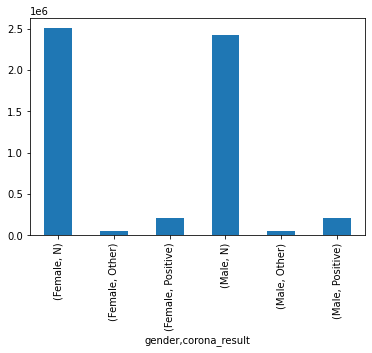

In [79]:
## EFFECT oF COVID On different Genders ### 

data.groupby(['gender','corona_result']).size().plot.bar()

<AxesSubplot:xlabel='age_60_and_above,corona_result'>

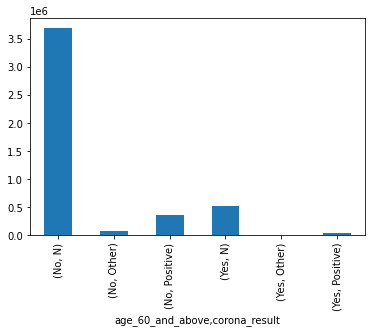

In [80]:
### Effect Of Covid On Elder People ###

data.groupby(['age_60_and_above','corona_result']).size().plot.bar()

In [9]:
group = data.groupby(['corona_result'])

#### Checking symptoms Ratio For Positive and Negative Diagnosed People 

<AxesSubplot:xlabel='corona_result'>

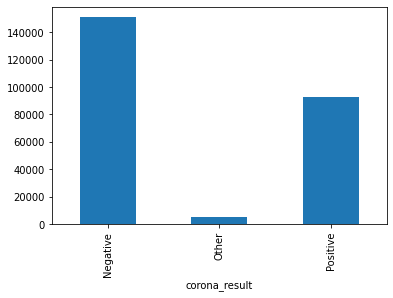

In [10]:
group['cough'].sum().plot.bar()

<AxesSubplot:xlabel='corona_result'>

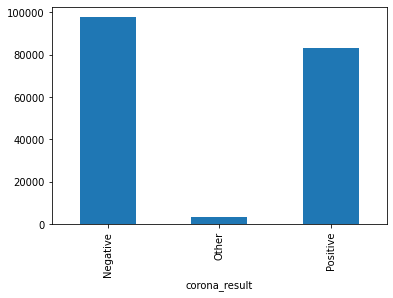

In [11]:
group['fever'].sum().plot.bar()

<AxesSubplot:xlabel='corona_result'>

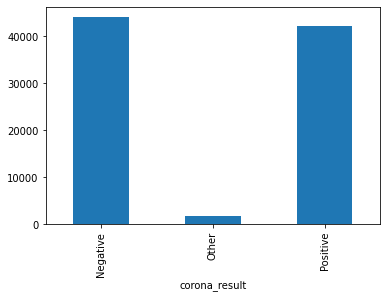

In [12]:
group['sore_throat'].sum().plot.bar()

<AxesSubplot:xlabel='corona_result'>

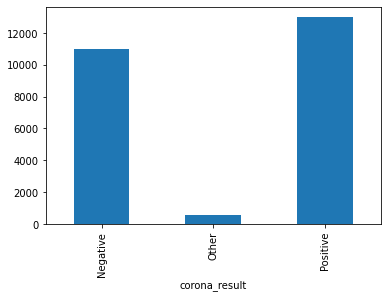

In [13]:
group['shortness_of_breath'].sum().plot.bar()

<AxesSubplot:xlabel='corona_result'>

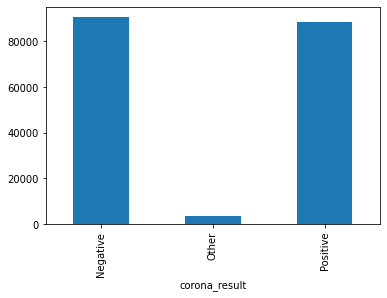

In [14]:
group['head_ache'].sum().plot.bar()

### It seems that headache and shortness of breath are major symptoms leading to Positive covid result.

<AxesSubplot:xlabel='corona_result'>

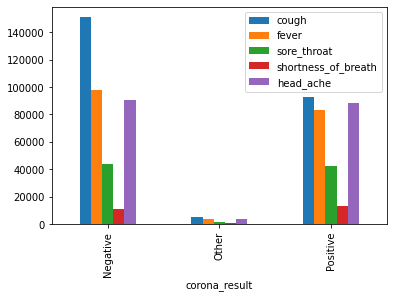

In [15]:
data.groupby('corona_result').sum().plot.bar()

#### A huge number of citizens with only cough were not covid postive

### Now we'll check simaultaneus symptom counts 

In [16]:
data['symptom count'] = data['cough']+data['fever']+data['sore_throat']+data['shortness_of_breath']+data['head_ache']

In [17]:
data.groupby(['symptom count','corona_result']).size()

symptom count  corona_result
0              Negative         4800859
               Other              96677
               Positive          234533
1              Negative          151064
               Other               5348
               Positive          101991
2              Negative           76807
               Other               2650
               Positive           62165
3              Negative           21438
               Other                816
               Positive           21917
4              Negative            5444
               Other                214
               Positive            5723
5              Negative             828
               Other                 33
               Positive             893
dtype: int64

<AxesSubplot:xlabel='symptom count,corona_result'>

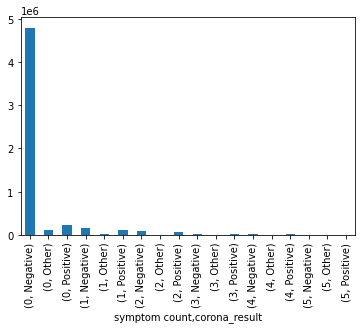

In [18]:
data.groupby(['symptom count','corona_result']).size().plot.bar()

### Very Interesting result as Majority of covid positive people didn't show any symptom, and only 893 people had covid positive and had all 5 symptoms

### Lets see spread of Covid aggregated on months

In [5]:
data['test_date'] = pd.to_datetime(data['test_date'],format="%Y-%m-%d")
data = data.set_index('test_date')

<AxesSubplot:xlabel='test_date'>

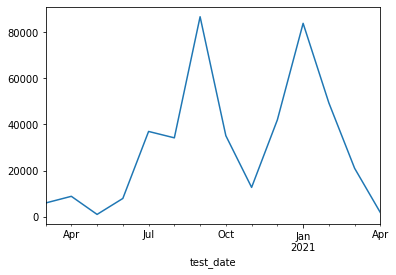

In [20]:
group = data[data['corona_result']=="Positive"].groupby(pd.Grouper(freq="M"))
group.count()['corona_result'].plot()

<AxesSubplot:xlabel='test_date'>

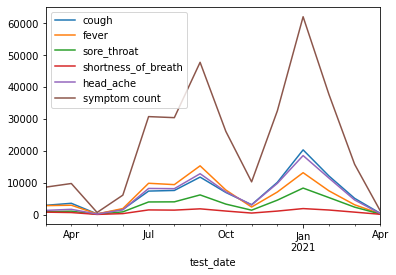

In [21]:
data[data['corona_result']=="Positive"].groupby(pd.Grouper(freq="M")).sum().plot()

In [26]:
### Saving Monthly Aggregated Data For Time Series Analysis ###

monthlydata = data.groupby(pd.Grouper(freq="M")).sum()
monthlydata.to_csv("MonthlyData.csv")

#### It is evident that with increase or decrease in number of positive covid cases, symptoms also followed the same trend, headache and fever being most prominent ones.

# Model Selection and Prediction

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from confusion_matrix import make_confusion_matrix

In [17]:
print(data.shape)
data = data.dropna()
print(data.shape)
print(data['corona_result'].value_counts())
data.head()

(5589400, 10)
(4700424, 10)
N           4201661
Positive     407061
Other         91702
Name: corona_result, dtype: int64


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
222843,2021-03-24,0,0,0,0,0,N,Yes,Male,Other
222844,2021-03-24,0,0,0,0,0,N,Yes,Male,Other
222845,2021-03-24,0,0,0,0,0,N,Yes,Male,Other
222846,2021-03-24,0,0,0,0,0,N,Yes,Female,Other
222847,2021-03-24,0,0,0,0,0,N,Yes,Male,Other


In [18]:
data['corona_result'] = LabelEncoder().fit_transform(data['corona_result'])
data['age_60_and_above'] = LabelEncoder().fit_transform(data['age_60_and_above'])
data['gender'] = LabelEncoder().fit_transform(data['gender'])
data = data.drop(['test_indication','test_date'],axis=1) 


In [8]:
data

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender
222843,0,0,0,0,0,0,1,1
222844,0,0,0,0,0,0,1,1
222845,0,0,0,0,0,0,1,1
222846,0,0,0,0,0,0,1,0
222847,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
5578438,0,0,0,0,0,0,0,0
5578439,0,0,0,0,0,0,0,1
5578440,1,1,0,0,0,0,0,0
5578441,0,0,0,0,0,0,0,1


In [8]:
Y = data['corona_result']
X = data.drop(["corona_result"],axis=1)
data = None
X

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender
222843,0,0,0,0,0,1,1
222844,0,0,0,0,0,1,1
222845,0,0,0,0,0,1,1
222846,0,0,0,0,0,1,0
222847,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...
5578438,0,0,0,0,0,0,0
5578439,0,0,0,0,0,0,1
5578440,1,1,0,0,0,0,0
5578441,0,0,0,0,0,0,1


In [37]:
models = {
    1:MultinomialNB(),
    2:DecisionTreeClassifier(),
    3:RandomForestClassifier(),
    4:MLPClassifier(hidden_layer_sizes=(32,64)),
}
names = {
    1:"MultinomialNB",
    2:"DecisionTreeClassifier",
    3:"RandomForestClassifier",
    4:"MLPClassifier",
}
model_tuples = []


In [12]:
### Cross Validation Over Four ML Models ###

for i in range(1,5):
    scores = cross_val_score(models[i],X,Y,cv=3)
    print("Validation Accuracy with {}".format(names[i]))
    print(scores)
    print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
    print("\n\n")


Validation Accuracy with MultinomialNB
[0.90051493 0.8946278  0.88416768]
0.8931 accuracy with a standard deviation of 0.0068



Validation Accuracy with DecisionTreeClassifier
[0.89840938 0.89706971 0.8831816 ]
0.8929 accuracy with a standard deviation of 0.0069



Validation Accuracy with RandomForestClassifier
[0.89838895 0.89733203 0.8831816 ]
0.8930 accuracy with a standard deviation of 0.0069



Validation Accuracy with MLPClassifier
[0.89800473 0.89708056 0.88318224]
0.8928 accuracy with a standard deviation of 0.0068





In [21]:
data['corona_result'].value_counts()

0    4201661
2     407061
1      91702
Name: corona_result, dtype: int64

###### Since the second Label "other" is not significant and it is not contributing in our training we will drop it

In [19]:
data = data[data['corona_result']!=1]
data['corona_result'].replace({2:1},inplace=True)
np.unique(data['corona_result'])

array([0, 1])

In [20]:
Y = data['corona_result']
X = data.drop(["corona_result"],axis=1)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Covid-", "Covid+"]
data= None

In [25]:

for i in range(1,5):
    scores = cross_val_score(models[i],X,Y,cv=3)
    print("Validation Accuracy with {}".format(names[i]))
    print(scores)
    print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
    print("\n\n")


Validation Accuracy with MultinomialNB
[0.91843272 0.91242845 0.90176079]
0.9109 accuracy with a standard deviation of 0.0069



Validation Accuracy with DecisionTreeClassifier
[0.91628527 0.91491895 0.90075509]
0.9107 accuracy with a standard deviation of 0.0070



Validation Accuracy with RandomForestClassifier
[0.91633995 0.91497949 0.90075509]
0.9107 accuracy with a standard deviation of 0.0070



Validation Accuracy with MLPClassifier
[0.91636208 0.91505044 0.89745417]
0.9096 accuracy with a standard deviation of 0.0086





In [33]:
### Training Ensemble Voting Classifier ###

model_tuples = [("MultinomialNB",MultinomialNB()),("DecisionTreeClassifier",DecisionTreeClassifier()),("RandomForestClassifier",RandomForestClassifier()),("MLPClassifier",MLPClassifier(hidden_layer_sizes=(32,64,128)))]

VC = VotingClassifier(estimators=model_tuples,n_jobs=-1)
scores = cross_val_score(VC, X, Y, cv=3)

In [34]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.91 accuracy with a standard deviation of 0.01


In [21]:
### Splitting Data in 70 and 30 ratio For Best Performing Algos ###

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

0.9119871952970345


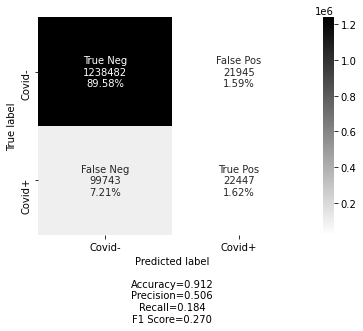

In [40]:
MNB = MultinomialNB()
MNB.fit(X_train,y_train)
pred = MNB.predict(X_test)
print(accuracy_score(y_test,pred))
cm = confusion_matrix(y_test,pred)
make_confusion_matrix(cm,group_names=labels,
                      categories=categories, 
                      cmap="binary")

0.9146842545694144


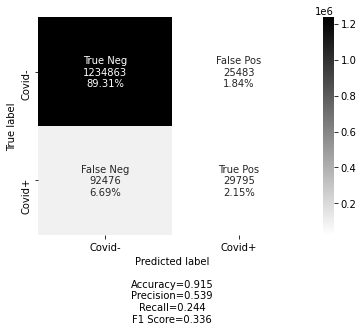

In [22]:
DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)
pred = DT.predict(X_test)
print(accuracy_score(y_test,pred))
cm = confusion_matrix(y_test,pred)
make_confusion_matrix(cm,group_names=labels,
                      categories=categories, 
                      cmap="binary")

0.915029252497257


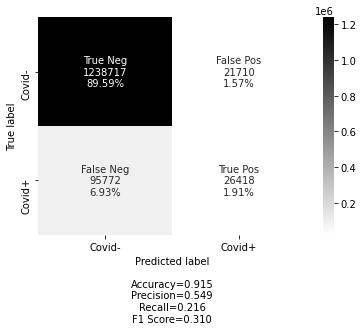

In [42]:
VC.fit(X_train,y_train)
pred = VC.predict(X_test)
print(accuracy_score(y_test,pred))
cm = confusion_matrix(y_test,pred)
make_confusion_matrix(cm,group_names=labels,
                      categories=categories, 
                      cmap="binary")

### It seems that Decision Tree has almost the same performance as Ensembles Voting Classifier. We can use Decision Tree For Our Project 

In [43]:
DT.fit(X,Y)

DecisionTreeClassifier()

In [44]:
import pickle
pickle.dump(DT, open("DTTrained", 'wb'))

In [45]:
loaded_model = pickle.load(open("DTTrained", 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9150914533815221


In [48]:
pred = loaded_model.predict([X_test.iloc[0]])
pred

array([1])

In [50]:
y_test.iloc[0]

1